Computational notebooks allow users to interleave text, code, and results in a single document. This notebook first demonstrates a simple calculation -- computing the first 25 numbers in the Fibonacci sequence, where each value equals the sum of the two previous values: $$F_n = F_{n-1} + F_{n-2}$$
Thus, the sequence is: 0, 1, 1, 2, 3, 5, 8, ...

The first cell contains an IPython 'magic' code, '%matplotlib', which allows the notebook to display plots inline, in the body of the notebook.

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# calculate the first 25 Fibonacci numbers
f1 = 0
f2 = 1
ar = [f1, f2] # a list to hold the computed values. We know the first two numbers

# we only need to run our calculation 23 times, because positions 1 and 2 are known
for i in range (23):
    f3 = f1 + f2
    ar.append (f3)
    f1 = f2
    f2 = f3
    
print (ar) # below, you see the output of the code itself.

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368]


Plot the data

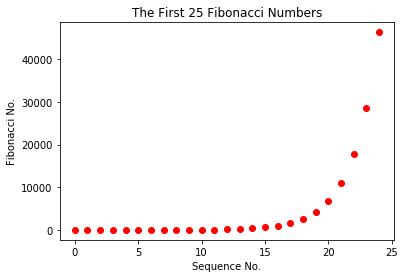

In [4]:
fig, ax = plt.subplots()
ax.plot (range(25), ar, "ro")
ax.set (xlabel = "Sequence No.", ylabel = "Fibonacci No.", 
       title = "The First 25 Fibonacci Numbers")
plt.show()

We can also add interactive maps, just like in our June mapping feature [mapping feature](https://www.nature.com/articles/d41586-018-05331-6). First, we use the built-in package manager, pip, to install the Python Leaflet library, folium. (**Uncomment this cell if you don't have folium already installed.**)

In [5]:
# !pip install folium

In [6]:
import folium

Now we create a simple map: a few points in London and Oxbridge, overlaid on either a street map, or on a map of geological data provided by the [Macrostrat Project](https://macrostrat.org/). (Click the tiles icon in the upper-right corner of the map to switch between the two layers.)

In [7]:
import pandas as pd

# create a data frame of locations
name = ["Nature", "Francis Crick Institute", "University College London", 
        "MRC Laboratory for Molecular Cell Biology", "Kings College London",
       "Imperial College London", "Cambridge University", "Oxford University",
       "Platform 9-3/4"]
lat = [51.533925,51.531877,51.524486,51.524435,51.511573,51.498780,52.206960,51.754843,51.532349]
long = [-0.121553,-0.128767,-0.133997,-0.132495,-0.116083,-0.174888,0.115034,-1.254302,-0.123806]

df = pd.DataFrame({'Name': name, 'Lat': lat, 'Long': long})

In [8]:
m = folium.Map(location = [51.8561, -0.2966], tiles = 'CartoDB positron', zoom_start = 9)

# add the locations to the map
for index,row in df.iterrows():
    folium.CircleMarker(
    location=[row['Lat'], row['Long']],
    popup=row['Name'],
    color=('blue' if row['Name'] == 'Nature' else 'crimson'),
    fill=False,
    ).add_to(m)

folium.TileLayer(tiles='https://tiles.macrostrat.org/carto/{z}/{x}/{y}.png', 
                 attr='Macrostrat', name='Macrostrat').add_to(m)
folium.LayerControl().add_to(m) # allow user to switch between layers
folium.LatLngPopup().add_to(m) # click on the map to get Lat/Long in a popup

Draw the map.

In [9]:
m

Collect session info, for computational reproducibility!

In [10]:
import IPython
print(IPython.sys_info())

{'commit_hash': 'd86648c5d',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/anaconda3/lib/python3.6/site-packages/IPython',
 'ipython_version': '6.1.0',
 'os_name': 'posix',
 'platform': 'Darwin-17.7.0-x86_64-i386-64bit',
 'sys_executable': '/anaconda3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.6.3 | packaged by conda-forge | (default, Oct  5 2017, '
                '19:18:17) \n'
                '[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]'}


In [11]:
!pip freeze

alabaster==0.7.10
anaconda-client==1.6.14
anaconda-navigator==1.8.7
anaconda-project==0.8.0
appnope==0.1.0
appscript==1.0.1
asn1crypto==0.22.0
astroid==1.5.3
astropy==2.0.2
Babel==2.5.0
backports.functools-lru-cache==1.4
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.0
bitarray==0.8.1
bkcharts==0.2
blaze==0.11.3
bleach==2.0.0
bokeh==0.12.10
boto==2.48.0
Bottleneck==1.2.1
branca==0.3.0
certifi==2018.4.16
cffi==1.10.0
chardet==3.0.4
click==6.7
cloudpickle==0.4.0
clyent==1.2.2
colorama==0.3.9
conda==4.5.4
conda-build==3.0.27
conda-verify==2.0.0
contextlib2==0.5.5
cryptography==2.0.3
cycler==0.10.0
Cython==0.26.1
cytoolz==0.8.2
dask==0.15.3
datashape==0.5.4
decorator==4.1.2
distributed==1.19.1
docutils==0.14
entrypoints==0.2.3
et-xmlfile==1.0.1
fastcache==1.0.2
filelock==2.0.12
Flask==0.12.2
Flask-Cors==3.0.3
folium==0.6.0
gevent==1.2.2
glob2==0.5
gmpy2==2.0.8
greenlet==0.4.12
h5py==2.7.1
heapdict==1.0.0
html5lib==0.999999999
idna==2.6
imageio==2.2.0
imagesize==0.7.1
ipykern